In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pickle 

In [40]:
transform = torchvision.transforms.ToTensor()
image_train = torchvision.datasets.SVHN(root='data/', split='train', download=True, transform=transform)  

Using downloaded and verified file: data/train_32x32.mat


In [41]:
batch = 256
train_loader = torch.utils.data.DataLoader(dataset=image_train, batch_size=batch, shuffle=True, num_workers=0)

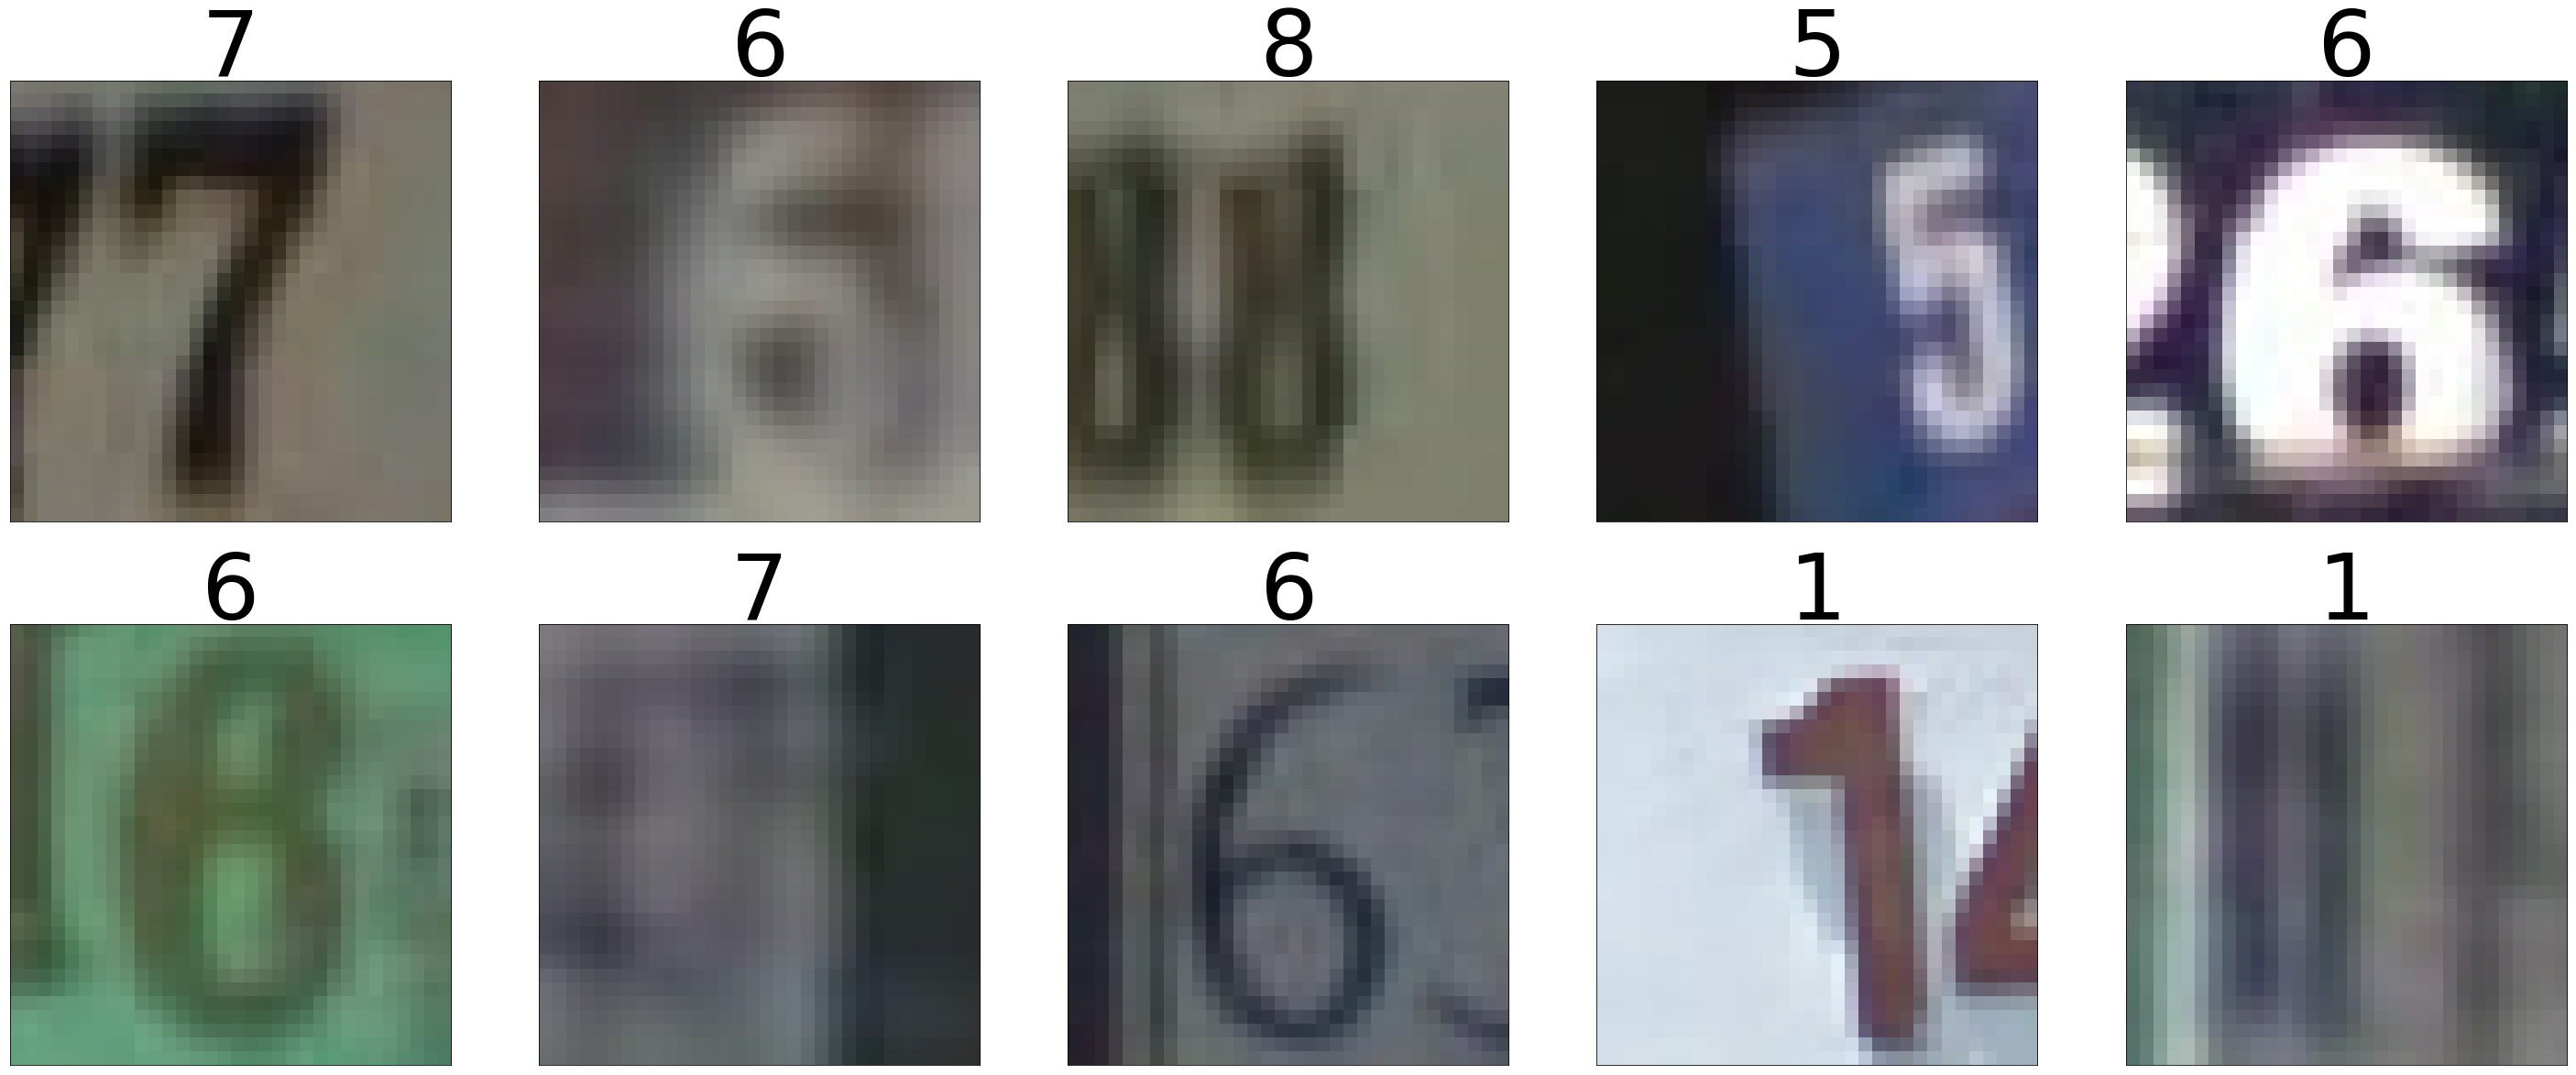

In [42]:
# Visualization
dataiter = iter(train_loader)
images, labels = dataiter.next()

fig = plt.figure(figsize=(50, 20))
plot_size=10
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(str(labels[idx].item()), fontsize= 100)

In [43]:
# Scaling 
def scale(x):
    # x is already in 0-1 range
    x = x*(2) + -1
    return x

In [44]:
def conv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

def deconv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                              kernel_size, stride, padding, bias=False)
    layers.append(transpose_conv_layer)
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [45]:
class Discriminator(nn.Module):
    def __init__(self, conv_dim=32):
        super().__init__()
        
        self.conv_dim = conv_dim
        
        self.conv1 = conv(3, conv_dim, batch_norm=False)
        self.conv2 = conv(conv_dim, conv_dim*2)
        self.conv3 = conv(conv_dim*2, conv_dim*4)
        
        self.fc = nn.Linear(conv_dim*4*4*4, 1)
        
    def forward(self, x):
        out = F.leaky_relu(self.conv1(x))
        out = F.leaky_relu(self.conv2(out))
        out = F.leaky_relu(self.conv3(out))
        
        out = out.view(-1, self.conv_dim*4*4*4)
        
        out = self.fc(out)
        return out

In [46]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim=32):
        super().__init__()

        self.conv_dim = conv_dim
        
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)

        self.t_conv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv2 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv3 = deconv(conv_dim, 3, 4, batch_norm=False)
        

    def forward(self, x):
        out = self.fc(x)
        out = out.view(-1, self.conv_dim*4, 4, 4) # (batch_size, depth, 4, 4)
        out = F.relu(self.t_conv1(out))
        out = F.relu(self.t_conv2(out))
        
        out = self.t_conv3(out)
        out = torch.tanh(out)
        
        return out

In [47]:
conv_dim = 32
z_size = 100

D = Discriminator(conv_dim)
G = Generator(z_size=z_size, conv_dim=conv_dim)

print(G.cuda(),'\n\n\n\n')
print(D.cuda())

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv3): Sequential(
    (0): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
) 




Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv

In [48]:
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

In [49]:
import torch.optim as optim

lr = 0.0001
beta1=0.5
beta2=0.999

d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

In [50]:
import pickle as pkl

# training hyperparams
num_epochs = 50

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 300

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        # important rescaling step
        real_images = scale(real_images)
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        
        d_optimizer.zero_grad()
        
        # 1. Train with real images

        # Compute the discriminator losses on real images 
        real_images = real_images.cuda()
        
        D_real = D(real_images)
        d_real_loss = real_loss(D_real)
        
        # 2. Train with fake images
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        # move x to GPU
        z = z.cuda()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images            
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # add up loss and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        z = z.cuda()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake) # use real loss to flip labels
        
        # perform backprop
        g_loss.backward()
        g_optimizer.step()
    
    ## AFTER EACH EPOCH##   
    # Print some loss stats
    # append discriminator loss and generator loss
    losses.append((d_loss.item(), g_loss.item()))
    # print discriminator and generator loss
    print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
            epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    # generate and save sample, fake images
    G.eval() # for generating samples
    fixed_z = fixed_z.cuda()
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to training mode


# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch [    1/   50] | d_loss: 0.1244 | g_loss: 3.0690
Epoch [    2/   50] | d_loss: 0.2265 | g_loss: 3.9011
Epoch [    3/   50] | d_loss: 0.6030 | g_loss: 3.9325
Epoch [    4/   50] | d_loss: 0.5968 | g_loss: 1.8284
Epoch [    5/   50] | d_loss: 0.7202 | g_loss: 2.3482
Epoch [    6/   50] | d_loss: 0.5818 | g_loss: 2.0656
Epoch [    7/   50] | d_loss: 0.3376 | g_loss: 2.0105
Epoch [    8/   50] | d_loss: 0.6385 | g_loss: 1.5256
Epoch [    9/   50] | d_loss: 0.5138 | g_loss: 2.8896
Epoch [   10/   50] | d_loss: 0.4022 | g_loss: 1.9870
Epoch [   11/   50] | d_loss: 0.4059 | g_loss: 2.0550
Epoch [   12/   50] | d_loss: 0.6402 | g_loss: 2.1388
Epoch [   13/   50] | d_loss: 0.6375 | g_loss: 1.7713
Epoch [   14/   50] | d_loss: 0.2760 | g_loss: 2.0093
Epoch [   15/   50] | d_loss: 0.3600 | g_loss: 2.1784
Epoch [   16/   50] | d_loss: 0.4394 | g_loss: 2.5564
Epoch [   17/   50] | d_loss: 0.3764 | g_loss: 3.5509
Epoch [   18/   50] | d_loss: 0.3043 | g_loss: 2.6907
Epoch [   19/   50] | d_loss

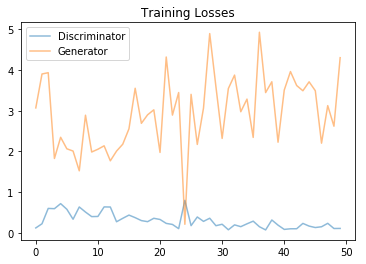

In [51]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [52]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img +1)*255 / (2)).astype(np.uint8) # rescale to pixel range (0-255)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

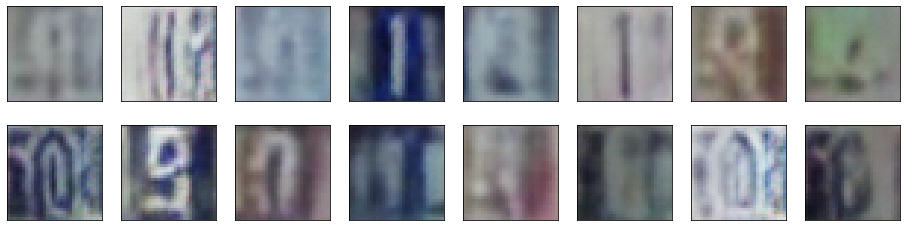

In [53]:
_ = view_samples(-1, samples)

In [55]:
## Not good enough result, gotta work on hyperparameters or increase epochs  